# Example prediction on a single test image

This notebook gives example code to make a single disparity prediction for one test image.

The file `test_simple.py` shows a more complete version of this code, which additionally:
- Can run on GPU or CPU (this notebook only runs on CPU)
- Can predict for a whole folder of images, not just a single image
- Saves predictions to `.npy` files and disparity images.

In [1]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

import networks
from utils import download_model_if_doesnt_exist

## Setting up network and loading weights

In [2]:
model_name = "mono_640x192"

download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval();

## Loading the test image and preprocessing

In [3]:
import numpy as np
from xml.etree import ElementTree
from xml.dom import minidom
import collections
import os
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
%matplotlib inline
import random
import cv2

#tokushimaの位置を指定する
dataset="drive_morning-0"
base_path = '/Users/gosato/Desktop/sekilab_3A2/models/research/deeplab/datasets/tokushima/' 


file_names = []
files = open(base_path + dataset+ "/" +dataset + '.txt' , 'r')

for file in files:
    file = file.rstrip('\n')
    file_names.append(file)
    
i=100

image_file=base_path + dataset+ "/" + file_names[i]

In [4]:
image_path = image_file

#ここをいじる

input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

## Prediction using the PyTorch model

In [5]:
with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]

## Plotting

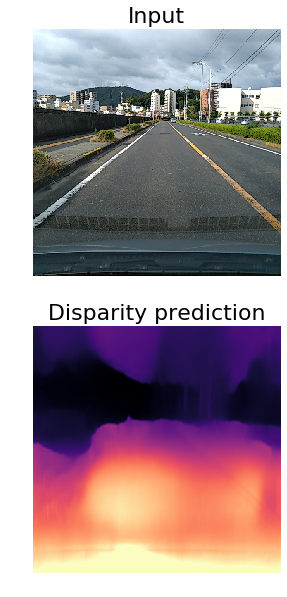

In [6]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');

In [7]:
1/disp_resized_np

array([[13.130294 , 13.107346 , 13.250415 , ...,  7.6505823,  7.694408 ,
         7.748299 ],
       [13.130294 , 13.107346 , 13.250415 , ...,  7.6505823,  7.694408 ,
         7.748299 ],
       [13.11098  , 13.083715 , 13.231635 , ...,  7.6448083,  7.6787105,
         7.7242866],
       ...,
       [ 1.8345295,  1.8496313,  1.8605517, ...,  1.8287367,  1.824881 ,
         1.8129666],
       [ 1.8320163,  1.8458073,  1.8565712, ...,  1.8236098,  1.8196146,
         1.8077449],
       [ 1.8320163,  1.8458073,  1.8565712, ...,  1.8236098,  1.8196146,
         1.8077449]], dtype=float32)

In [8]:
disp_resized_np

array([[0.07615976, 0.0762931 , 0.07546934, ..., 0.130709  , 0.12996452,
        0.12906058],
       [0.07615976, 0.0762931 , 0.07546934, ..., 0.130709  , 0.12996452,
        0.12906058],
       [0.07627195, 0.07643089, 0.07557645, ..., 0.13080773, 0.1302302 ,
        0.1294618 ],
       ...,
       [0.5450989 , 0.5406483 , 0.537475  , ..., 0.5468256 , 0.54798096,
        0.55158216],
       [0.54584664, 0.5417684 , 0.5386273 , ..., 0.5483629 , 0.5495669 ,
        0.5531754 ],
       [0.54584664, 0.5417684 , 0.5386273 , ..., 0.5483629 , 0.5495669 ,
        0.5531754 ]], dtype=float32)

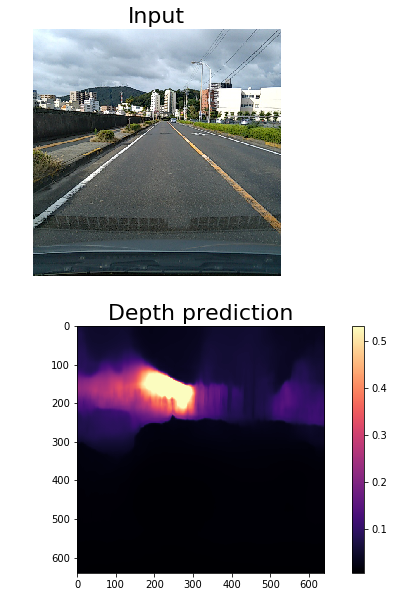

In [9]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow((1/disp_resized_np)/np.max(1/disp_resized_np), cmap='magma', vmax=vmax)
plt.title("Depth prediction", fontsize=22)
plt.colorbar()
plt.axis('on');


In [25]:
np.max(1/disp_resized_np)

26.615309

In [26]:
np.min(1/disp_resized_np)

1.786813

In [24]:
depth=1/disp_resized_np

In [12]:
np.unravel_index(np.argmax(depth),depth.shape)

(485, 991)